# Convolutional Neural Network 📷

* **Note**: we initially explored creating a convolutional neural network from scratch using TensorFlow (without using the Keras library); while it was an interesting experiment in understanding how tensors are structured and what's happening behind the scenes, we found the implementation to be too complicated for the scope of this project; this is a partially complete notebook

In this notebook, we will create a Convolutional Neural Network that detects dog breeds. This will not be the most powerful machine learning model for dog breed detection. For this problem, [transfer learning](https://en.wikipedia.org/wiki/Transfer_learning) is much better, where we will use weights and neural network architecture from another model (ImageNet) to create a model more finally tuned for this dataset. However, in order to gain an intuition for how these models work, it is best that we create a machine learning model from scratch before we create a Transfer Learning model. We can then compare this model to a pretrained model.

* [this notebook](https://www.kaggle.com/kaggleslayer/simple-convolutional-n-network-with-tensorflow) does an excellent job explaining how to build a model using Tensorflow
  * the author makes the distinction that Keras isn't used (which would be better suited for the pretrained models)
* [TensorFlow-Tutorials](https://github.com/Hvass-Labs/TensorFlow-Tutorials)

## Importing Data

* see the [Data Analysis notebook](https://colab.research.google.com/drive/1xSQsVrdrJDSaq3FFPmJQBiE58T8N7SC3#scrollTo=-zlGN7ZcRS4d) for more information on how the data is structured and cleaned

We will not load the test set data because this is for the dataset's associated Kaggle competition only and assumes that all labels will be used. For this CNN, only the top N labels will be trained so this test data set is not relevant. 

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

data_path = '/content/gdrive/My Drive/dogs/data/dog-breed-identification/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


* first let's grab our labels as a pandas dataframe

In [0]:
import tensorflow as tf
tf.__version__

'1.15.0'

In [0]:
import pandas as pd

labels = pd.read_csv(data_path + 'labels.csv')

labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [0]:
test_ids = pd.read_csv(data_path + 'sample_submission.csv').id

test_ids.head()

0    000621fb3cbb32d8935728e48679680e
1    00102ee9d8eb90812350685311fe5890
2    0012a730dfa437f5f3613fb75efcd4ce
3    001510bc8570bbeee98c8d80c8a95ec1
4    001a5f3114548acdefa3d4da05474c2e
Name: id, dtype: object

* next lets grab our training and test data



In [0]:
import pickle 

training_data = pickle.load(open(data_path + "train_numpy.p", "rb"))

* Let's verify that our data was loaded in the correct order

In [0]:
training_data.shape

(10222, 60, 60, 3)

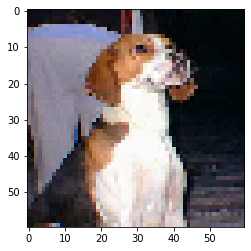

In [0]:
import matplotlib.pyplot as plt

plt.imshow(training_data[1234])

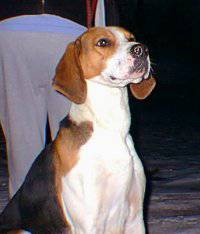

In [0]:
from IPython.display import Image

Image(data_path + 'train/' + labels.id[1234] + ".jpg")

It looks like it has! 🐶

## Preparing Data

In this section, we will go over how to prepare our data for our model. In our [Data Analysis notebook](https://colab.research.google.com/drive/1xSQsVrdrJDSaq3FFPmJQBiE58T8N7SC3#scrollTo=-zlGN7ZcRS4d), we transformed our image data into numpy arrays so the network could read our data. Now we must filter data by the top-n breeds and encode our labels into something legible for the network. 

To do this, we will create a function that returns the top-n:
  1. filtered labels
  2. filtered data
  3. map of labels (for one-hot encoding)
  3. one-hot encoded labels

### Selecting N most popular breeds

This covers the first two steps we are trying to achieve for our data preperation. Reducing our labels makes our model less complicated, but it also significantly reduces the amount of data we have to train with.

In [0]:
def top_n(n):
  """
  Get the top_n breeds of the dataset and
  returns an array of the top_n labels
    * assumes labels is a global value
  """

  # get the top_n labels
  top_n = list(labels["breed"].value_counts()[:n].axes[0])
  
  # Cool Print Statement
  print("These are the top " + str(n) + " breeds: \n\n" 
        + '\n'.join(str(x[0] + 1) + ". " + str(x[1]) for x in enumerate(top_n)))
  
  #top_n_labels = list(labels[labels.breed.isin(top_n)].index)
  
  return labels[labels.breed.isin(top_n)]

In [0]:
top_5_labels = top_n(5)

These are the top 5 breeds: 

1. scottish_deerhound
2. maltese_dog
3. afghan_hound
4. entlebucher
5. bernese_mountain_dog


In [0]:
# get the corresponding training data from the top_5 labels

top_5_training_data = training_data[list(top_5_labels.index)]

In [0]:
top_5_training_data.shape

(588, 60, 60, 3)

### One-Hot Encoding Labels

One-Hot encoding turns our labels into an array of 1's and 0's, similar to what is seen in sample submission CSV. Each image has an array to represent it's label. Each index in the array represents a specific label, and the label corresponding to an image is marked with a 1 (this data structure is shown below).

* [One-Hot Encoding Explained](https://www.youtube.com/watch?v=v_4KWmkwmsU)


In [0]:
import numpy as np

top_5_labels_map = list(top_5_labels.breed.unique())

top_5_labels_breeds = top_5_labels.breed.values

top_5_labels_one_hot = np.zeros((top_5_labels_breeds.size, 5))

for label in enumerate(top_5_labels_breeds):
  top_5_labels_one_hot[label[0]][top_5_labels_map.index(label[1])] = 1

## print everything

print(top_5_labels_map)

print()

print(top_5_labels_one_hot)

print()

print(list(map(lambda one_hot: top_5_labels_map[one_hot.tolist().index(1)], top_5_labels_one_hot)))

['scottish_deerhound', 'maltese_dog', 'entlebucher', 'bernese_mountain_dog', 'afghan_hound']

[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]

['scottish_deerhound', 'maltese_dog', 'scottish_deerhound', 'entlebucher', 'entlebucher', 'maltese_dog', 'bernese_mountain_dog', 'entlebucher', 'afghan_hound', 'scottish_deerhound', 'maltese_dog', 'bernese_mountain_dog', 'bernese_mountain_dog', 'bernese_mountain_dog', 'maltese_dog', 'scottish_deerhound', 'scottish_deerhound', 'scottish_deerhound', 'maltese_dog', 'afghan_hound', 'bernese_mountain_dog', 'afghan_hound', 'bernese_mountain_dog', 'bernese_mountain_dog', 'bernese_mountain_dog', 'afghan_hound', 'scottish_deerhound', 'afghan_hound', 'afghan_hound', 'afghan_hound', 'maltese_dog', 'scottish_deerhound', 'bernese_mountain_dog', 'entlebucher', 'scottish_deerhound', 'bernese_mountain_dog', 'afghan_hound', 'entlebucher', 'maltese_dog', 'entlebucher', 'afghan_hound', 'entlebucher'

### A Function For Everything

We will now put everything into one function. This way, we can easily control the number of groups we would like our model to have.

In [0]:
def prepare_data(n, labels, data):
  """
  Returns the following items:
    1. Filtered Top-N Labels 
    2. Filtered Top-N Data
    3. Map of Labels for One-Hot Encoding (list form)
    4. One-Hot Encoded Labels
  """

  # get the top_n labels
  top_n = list(labels["breed"].value_counts()[:n].axes[0])

  top_n_labels = labels[labels.breed.isin(top_n)]
  
  top_n_data = data[list(top_n_labels.index)]

  # One - Hot Encoding Section
  top_n_labels_map = list(top_n_labels.breed.unique())

  top_n_labels_breeds = top_n_labels.breed.values

  top_n_labels_one_hot = np.zeros((top_n_labels_breeds.size, n))

  for label in enumerate(top_n_labels_breeds):
    top_n_labels_one_hot[label[0]][top_n_labels_map.index(label[1])] = 1

  return (top_n_labels, top_n_data, top_n_labels_map, top_n_labels_one_hot)

* now lets pull data for our top 10 groups

In [0]:
top_10_labels, top_10_data, top_10_labels_map, top_10_labels_one_hot = prepare_data(10, labels, training_data)

In [0]:
top_10_labels.head()

,id,breed
8,003df8b8a8b05244b1d920bb6cf451f9,basenji
9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound
12,00693b8bc2470375cc744a6391d397ec,maltese_dog
57,0162b3e0144fb1d1ab82fbff3ace9938,shih-tzu
70,01b36cb1b80ab8c3a7d2b7128ad21bdc,samoyed


In [0]:
top_10_data.shape

(1141, 60, 60, 3)

In [0]:
top_10_labels_map

['basenji',
 'scottish_deerhound',
 'maltese_dog',
 'shih-tzu',
 'samoyed',
 'entlebucher',
 'bernese_mountain_dog',
 'afghan_hound',
 'great_pyrenees',
 'pomeranian']

In [0]:
top_10_labels_one_hot.shape

(1141, 10)

## Building our Model

* include an image of our final model using the [NN-SVG](https://alexlenail.me/NN-SVG/) tool

* We will be running the Keras library on top of TensorFlow, a popular Machine Learning library

Our model will be using TensorFlow. 

### Learning

* Follow [this tutorial](https://www.kaggle.com/learn/deep-learning) to get the theory behind deep learning down
  * our data is included in this tutorial series
  * also includes a section on Transfer Learning (which is another step we should consider for making a more powerful model)

* another super [helpful resource](https://github.com/priya-dwivedi/Deep-Learning/blob/master/Dog-breed-classifier/dog_app.ipynb)

In [0]:
from sklearn.model_selection import train_test_split

num_validation = 0.20

X_train, X_validation, y_train, y_validation = train_test_split(top_10_data, top_10_labels, test_size=num_validation, random_state=6)
X_train.shape

(912, 60, 60, 3)

In [0]:
X_validation.shape

(229, 60, 60, 3)

Image resize

In [0]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense

img_size = 60
num_channels = 3
img_size_flat = 60 * 60
img_shape = (60, 60, 3)
num_classes = 10

model = Sequential()

# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 32         # There are 32 of these filters.

# Convolutional Layer 2.
filter_size2 = 4          # Convolution filters are 4 x 4 pixels.
num_filters2 = 64      # There are 64 of these filters.

# Convolutional Layer 3.
filter_size3 = 3          # Convolution filters are 3 x 3 pixels.
num_filters3 = 128      # There are 128 of these filters.

model.add(Conv2D(num_filters1, (filter_size1, filter_size1), padding='same', input_shape = img_shape, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(num_filters2, (filter_size2, filter_size2), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(num_filters3, (filter_size3, filter_size3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Flatten())


## Analysis

In [0]:
print("Hello there")